In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 60713791.02it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78967205.88it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19747784.61it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14312944.23it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    # fake_labels = torch.ones_like(logits_fake, device=logits_fake.device)
    # loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, fake_labels, reduction='mean')
    # print(true_label)
    loss = criterion(output, true_label)
    loss.backward()

    return loss
    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    # real_labels = torch.ones_like(logits_real, device=logits_real.device)
    # real_loss = nn.functional.binary_cross_entropy_with_logits(logits_real, real_labels, reduction='mean')
    loss = criterion(output, true_label)
    loss.backward()

    # fake_labels = torch.zeros_like(logits_fake, device=logits_fake.device)
    # fake_loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, fake_labels, reduction='mean')
    # loss = (real_loss + fake_loss)

    return loss
    ######################################

def discriminator_loss(true_output, real_labels, fake_output, fake_labels):
    ############ YOUR CODE HERE ##########

    # real_labels = torch.ones_like(logits_real, device=logits_real.device)
    # real_loss = nn.functional.binary_cross_entropy_with_logits(logits_real, real_labels, reduction='mean')
    real_loss = criterion(true_output, real_labels)

    # fake_labels = torch.zeros_like(logits_fake, device=logits_fake.device)
    fake_loss = criterion(fake_output, fake_labels)
    real_loss.backward()
    fake_loss.backward()
    loss = (real_loss + fake_loss)

    return loss
    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########


        ####### MY PREPROCESSING CODE #######


        # data[0] is 512 x 1 x 28 x 28, 512 black and white 28 x 28 images
        # data[1] is 512, 512 labels

        d_total_error = None
        # pre-process data
        all_images = data[0]
        all_labels = data[1]
        all_images = all_images.to(device)

        # normalized_image = (((all_images - torch.min(all_images)) / torch.max(all_images)) * 2) - 1

        # randomly sample 64 indices WITHOUT replacement
        real_image_sample_indices = np.random.choice(all_images.shape[0], sample_size, replace = False)
        minibatch_real_data = all_images[real_image_sample_indices, :, :, :]
        minibatch_real_labels = all_labels[real_image_sample_indices]


        ####### END OF MY PREPROCESSING CODE #######

        ####### MY DISCRIMINATOR CODE #######


        optim_d.zero_grad()
        # reshaped_minibatch_real_data = minibatch_real_data.reshape(minibatch_real_data.shape[0], -1)
        reshaped_minibatch_real_data = minibatch_real_data
        real_image_discriminator_output = discriminator(reshaped_minibatch_real_data)

        noise = create_noise(sample_size, nz)
        fake_images = generator(noise)
        # TODO: this reshape might not be right - not sure if need to reshape
        # to [batch_size, 1, 28, 28] and then flatten?
        fake_image_discriminator_output = discriminator(fake_images.reshape(reshaped_minibatch_real_data.shape[0], -1))

        real_labels = label_real(sample_size)
        fake_labels = label_fake(sample_size)

        loss_d += discriminator_loss(real_image_discriminator_output, real_labels, fake_image_discriminator_output, fake_labels).item()
        # loss_d.backward()
        optim_d.step()


        ####### END OF MY DISCRIMINATOR CODE #######

        ####### MY GENERATOR CODE #######


        g_error = None
        fake_images = None

        optim_g.zero_grad()
        noise = create_noise(sample_size, nz)
        fake_images = generator(noise)
        fake_image_discriminator_output = discriminator(fake_images.reshape(reshaped_minibatch_real_data.shape[0], -1))
        loss_g += generator_loss(fake_image_discriminator_output, fake_labels)
        # loss_g.backward()
        optim_g.step()


        ####### END OF MY GENERATOR CODE #######


        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0 or epoch == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Output hidden; open in https://colab.research.google.com to view.

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

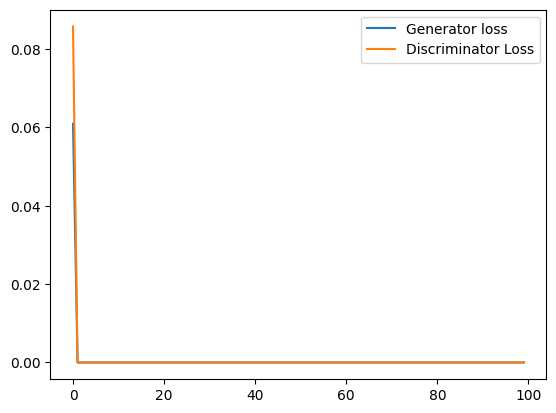

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot([val.detach().numpy() for val in losses_g], label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')